# A first attempt at modelling using Julia

✨ Economic data 📊 , Julia 🤗 and Jupyter🪐

The setup : libs & data

In [1]:
using DataFrames, DataFramesMeta, BrowseTables, Parquet
using Distributions, StatsPlots, Statistics
using Plots
using LaTeXStrings

In [2]:
df = DataFrame(read_parquet("./data/data-clean-full-latest.parquet"))

latexstring("\\text{Number of observations: } $(size(df, 1))")

L"$\text{Number of observations: } 22160$"

# What we aim to do

Here we hate two values, $Q(p)$ and $p$, where $p$ is a percentile and $Q$ the Quantile function.  

You could conversely see it as $q$ and $F(q)$, where $q$ is a quantile and $F$ the CDF.

We want to find a decent model for $F$. We'll try a few methods first:

* The classic Q-Q plot eyeballing
* The Kolmogorov-Smirnov test (based on the $L_\infty$ norm $||F-\hat{F}||_\infty$)
* The so-called Anderson-Darling test (based on the $L_2$ norm $||F-\hat{F}||_2$)

Let's first look at the data: the true model actually depends on $\langle t, k, p \rangle$ (time, country and percentile), but we'll ignore that for now.

In [ ]:
# HIDE CODE

dfg = groupby(df, :rel_income)

dfr = hcat(
    combine(dfg,
        :perc => ((p) -> quantile(p, 0.025)) => :perc_025,
        :perc => ((p) -> quantile(p, 0.05)) => :perc_05,
        :perc => ((p) -> quantile(p, 0.25)) => :perc_25,
        :perc => ((p) -> quantile(p, 0.5)) => :perc_50,
        :perc => ((p) -> quantile(p, 0.75)) => :perc_75,
        :perc => ((p) -> quantile(p, 0.95)) => :perc_95,
        :perc => ((p) -> quantile(p, 0.975)) => :perc_975,
        ),
    combine(dfg,
        :perc => mean => :perc_mean,
        :perc => std => :perc_std,
        ),
        makeunique=true
)

latexstring("\\\\
\\text{If we consider the percentile }P \\;\\text{as a variable of income}\\;r,\\\\
\\text{then we can estimate the following parameters:}\\\\
\\\\
\\mu(P) = $(round(mean(df.perc), digits=2)) \\\\
\\sigma(P) = $(round(std(df.perc), digits=2))\\\\
\\\\
\\text{The } 95\\%
\\text{ confidence interval for the mean is:} \\\\\\\\
C_l\\coloneqq \\mu(P) - 2\\cdot\\sigma(P) = $(round(mean(df.perc) - 2*std(df.perc), digits=2))\\\\
C_u\\coloneqq \\mu(P) + 2\\cdot\\sigma(P) = $(round(mean(df.perc) + 2*std(df.perc), digits=2))"
)

In [20]:
using CSV ; CSV.write("./data/data-clean-full-latest-x-y-cdf.csv", dfr)

"./data/data-clean-full-latest-x-y-cdf.csv"

Let's estimate upper and lower confidence bounds for the CDF function $F$.

In [21]:
dfr = hcat(
    dfr,
    combine(dfr,
        [:perc_mean, :perc_std] => ByRow.((m,s) -> m + 2 * s) => :perc_upper_std,
        [:perc_mean, :perc_std] => ByRow.((m,s) -> m - 2 * s) => :perc_lower_std
        ),
    makeunique=true
)
dfr = select(dfr, Not(:rel_income_1))

latexstring("")

L"$$"

In [22]:
CSV.write("./data/data-clean-full-latest-x-y-cdf.csv", dfr)

"./data/data-clean-full-latest-x-y-cdf.csv"

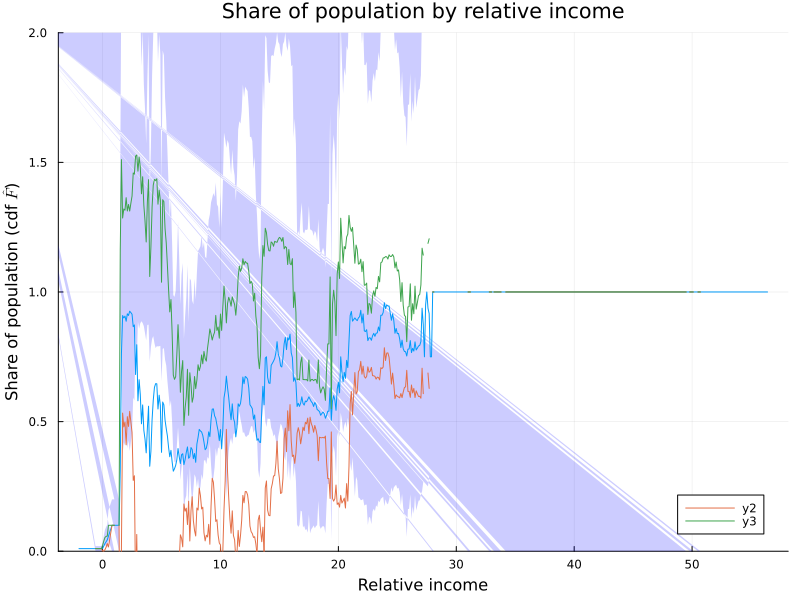

In [23]:
# HIDE CODE

_dfr = dropmissing(sort(dfr, :rel_income))

plot(
    _dfr.rel_income,
    _dfr.perc_mean,
    ribbon=(_dfr.perc_lower_std, _dfr.perc_upper_std),
    fillalpha=0.2,
    fillcolor=:blue,
    label="",
    xlabel="Relative income",
    ylabel=L"Share of population (cdf $\hat{F}$)",
    title="Share of population by relative income",
    legend=:bottomright,
    size=(800, 600),
    ylims=(0, 2),
    )
plot!(
    _dfr.rel_income,
    [_dfr.perc_lower_std, _dfr.perc_upper_std],
)

Due to marginalisation across two dimensions, we have a 1D distribution, which we can plot as a curve.

But we can clearly see the undertainty. Let's see the quantiles.

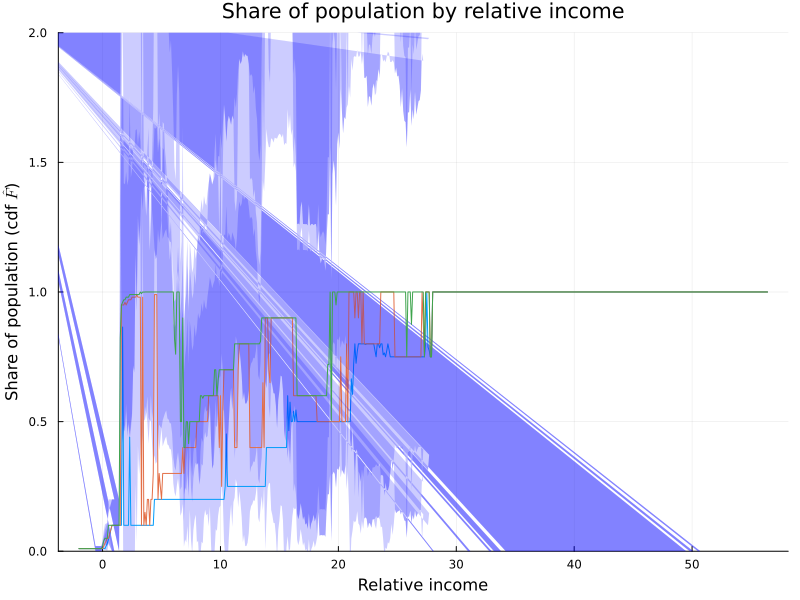

In [24]:
# HIDE CODE

plot(
    _dfr.rel_income,
    [_dfr.perc_05, _dfr.perc_50, _dfr.perc_95],
    ribbon=(_dfr.perc_lower_std, _dfr.perc_upper_std),
    fillalpha=0.2,
    fillcolor=:blue,
    label="",
    xlabel="Relative income",
    ylabel=L"Share of population (cdf $\hat{F}$)",
    title="Share of population by relative income",
    legend=:bottomright,
    size=(800, 600),
    ylims=(0, 2),
    )

Similar pattern, more square-ish. Let's see what we can do with it.